# Loading and exploring the swaptions data

Quick notebook for hackathon participants to:
- load the train Excel file into pandas
- convert it to a PyTorch `Dataset`
- visualize the surface with a heatmap, a few time series, and evolution snapshots / GIF

In [1]:
# useful importations
from pathlib import Path
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# navigating your repository
PROJECT_ROOT = os.path.abspath("/content/drive/MyDrive/MilHaQ_Fest/Participants/Track2_QML")

DATA_PATH = os.path.join(PROJECT_ROOT, "train.xlsx")
PLOTS_DIR = os.path.join(PROJECT_ROOT, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Using project root: {PROJECT_ROOT}")
print(f"Train data path: {DATA_PATH}")
print(f"Plots will be saved to: {PLOTS_DIR}")

Using project root: /content/drive/MyDrive/MilHaQ_Fest/Participants/Track2_QML
Train data path: /content/drive/MyDrive/MilHaQ_Fest/Participants/Track2_QML/train.xlsx
Plots will be saved to: /content/drive/MyDrive/MilHaQ_Fest/Participants/Track2_QML/plots


## Load the training data

In [ ]:
# Load training data (day-first dates)
df = pd.read_excel(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

# Keep Date as first column
df = df[['Date'] + [c for c in df.columns if c != 'Date']]
feature_cols = [c for c in df.columns if c != 'Date']

df.head()

print(f"Rows: {len(df)}")
print(f"Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Number of surface points: {len(feature_cols)}")

Rows: 494
Date range: 2050-01-01 → 2051-12-23
Number of surface points: 224


## Build a Torch dataset

In [ ]:
# Build a simple PyTorch Dataset using the next-day target
import sys
sys.path.append(PROJECT_ROOT)

from data import SwaptionDataset

X = df[feature_cols].copy()
y = df[feature_cols].shift(-1)

# drop last row where target is NaN
mask = ~y.isnull().any(axis=1)
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

dataset = SwaptionDataset(X, y)
print(f"Dataset size: {len(dataset)} samples")
print(f"Feature dim: {X.shape[1]}, Target dim: {y.shape[1]}")

Dataset size: 493 samples
Feature dim: 224, Target dim: 224


## Visualize the data

In [ ]:
# Parsing helpers
def parse_surface_metadata(df):
    tenors, maturities = [], []
    mapping = {}
    for col in df.columns:
        if col == 'Date':
            continue
        parts = col.split(';')
        tenor = float(parts[0].split(':')[1].strip())
        maturity = float(parts[1].split(':')[1].strip())
        tenors.append(tenor)
        maturities.append(maturity)
        mapping[col] = (tenor, maturity)
    return sorted(set(tenors)), sorted(set(maturities)), mapping

def surface_for_date(df, idx, unique_tenors, unique_maturities, mapping):
    row = df.iloc[idx]
    surface = np.full((len(unique_tenors), len(unique_maturities)), np.nan)
    for col, (t, m) in mapping.items():
        t_idx = unique_tenors.index(t)
        m_idx = unique_maturities.index(m)
        surface[t_idx, m_idx] = row[col]
    return surface

unique_tenors, unique_maturities, tm_map = parse_surface_metadata(df)
print(f"Tenors: {len(unique_tenors)} | Maturities: {len(unique_maturities)}")

Tenors: 14 | Maturities: 16


### Some time series using a few key strikes

Saved /content/drive/MyDrive/MilHaQ_Fest/Participants/Track2_QML/plots/time_series.png


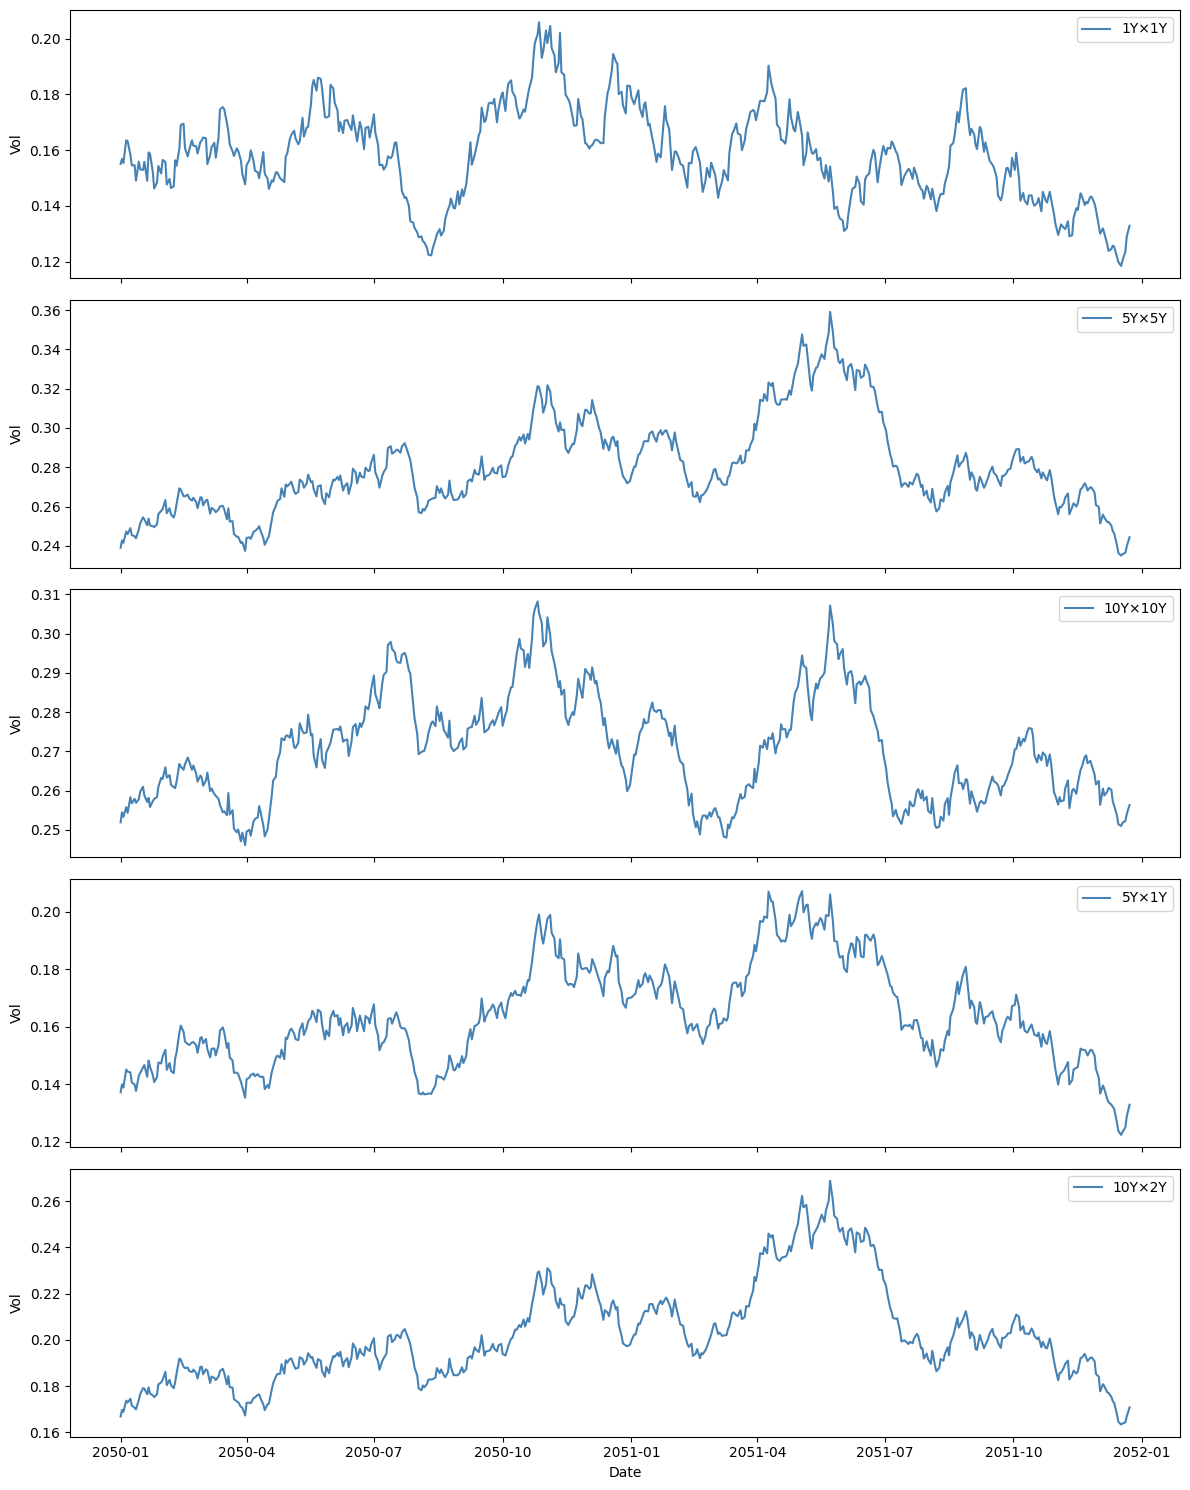

In [ ]:
# Time series for a few key strikes
key_strikes = [
    (1, 1, '1Y×1Y'),
    (5, 5, '5Y×5Y'),
    (10, 10, '10Y×10Y'),
    (5, 1, '5Y×1Y'),
    (10, 2, '10Y×2Y'),
]

fig, axes = plt.subplots(len(key_strikes), 1, figsize=(12, 3*len(key_strikes)), sharex=True)
for ax, (tenor, maturity, label) in zip(axes, key_strikes):
    col = None
    for c, (t, m) in tm_map.items():
        if abs(t - tenor) < 0.01 and abs(m - maturity) < 0.01:
            col = c
            break
    if col is None:
        ax.text(0.5, 0.5, f"Missing {label}", ha='center', va='center')
        continue
    ax.plot(df['Date'], df[col], label=label, color='steelblue')
    ax.set_ylabel('Vol')
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()
time_series_path = os.path.join(PLOTS_DIR,'time_series.png')
fig.savefig(time_series_path, dpi=200)
print(f"Saved {time_series_path}")
plt.show()

### Heatmap

Saved /content/drive/MyDrive/MilHaQ_Fest/Participants/Track2_QML/plots/heatmap_latest.png


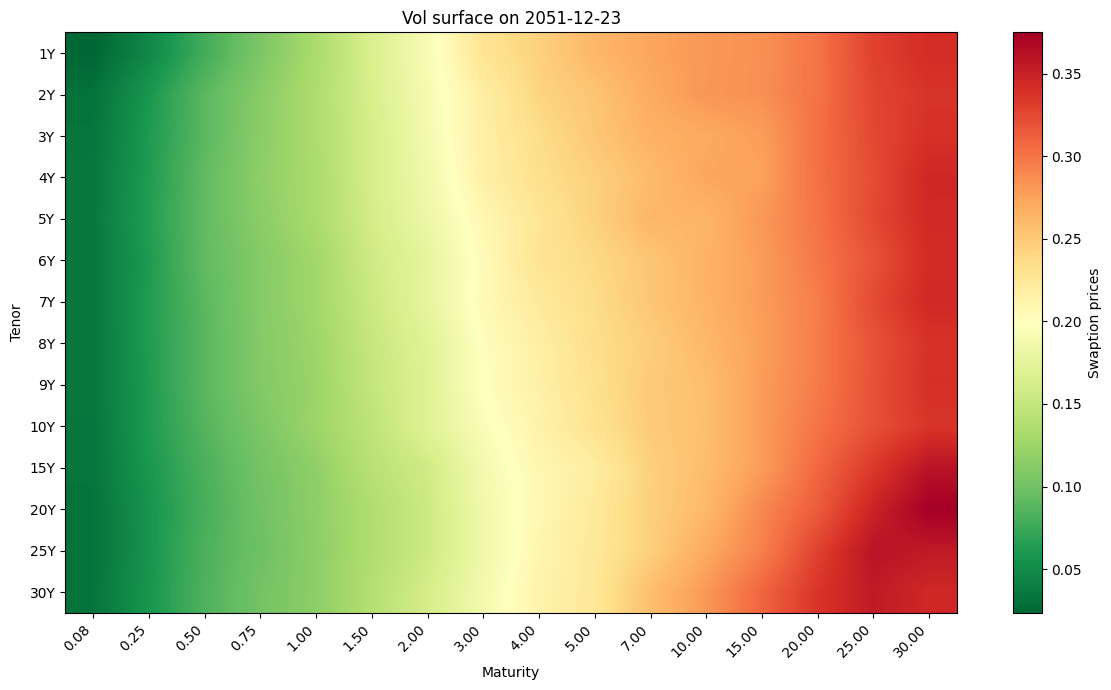

In [ ]:
# Heatmap for the latest date
def plot_heatmap(df, index=-1, save=False):
    surface = surface_for_date(df, index, unique_tenors, unique_maturities, tm_map)
    fig, ax = plt.subplots(figsize=(12, 7))
    im = ax.imshow(surface, cmap='RdYlGn_r', aspect='auto', interpolation='bilinear')
    ax.set_title(f"Swaption prices on {df['Date'].iloc[index].date()}")
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Tenor')
    ax.set_xticks(range(len(unique_maturities)))
    ax.set_yticks(range(len(unique_tenors)))
    ax.set_xticklabels([f"{m:.2f}" for m in unique_maturities], rotation=45, ha='right')
    ax.set_yticklabels([f"{t:.0f}Y" for t in unique_tenors])
    plt.colorbar(im, ax=ax, label='Swaption prices')
    plt.tight_layout()
    if save:
        path = os.path.join(PLOTS_DIR,'heatmap_latest.png')
        fig.savefig(path, dpi=200)
        print(f"Saved {path}")
    return fig

plot_heatmap(df, index=-1, save=True)
plt.show()

### Surface evolution

Saved /content/drive/MyDrive/MilHaQ_Fest/Participants/Track2_QML/plots/evolution_snapshots.png


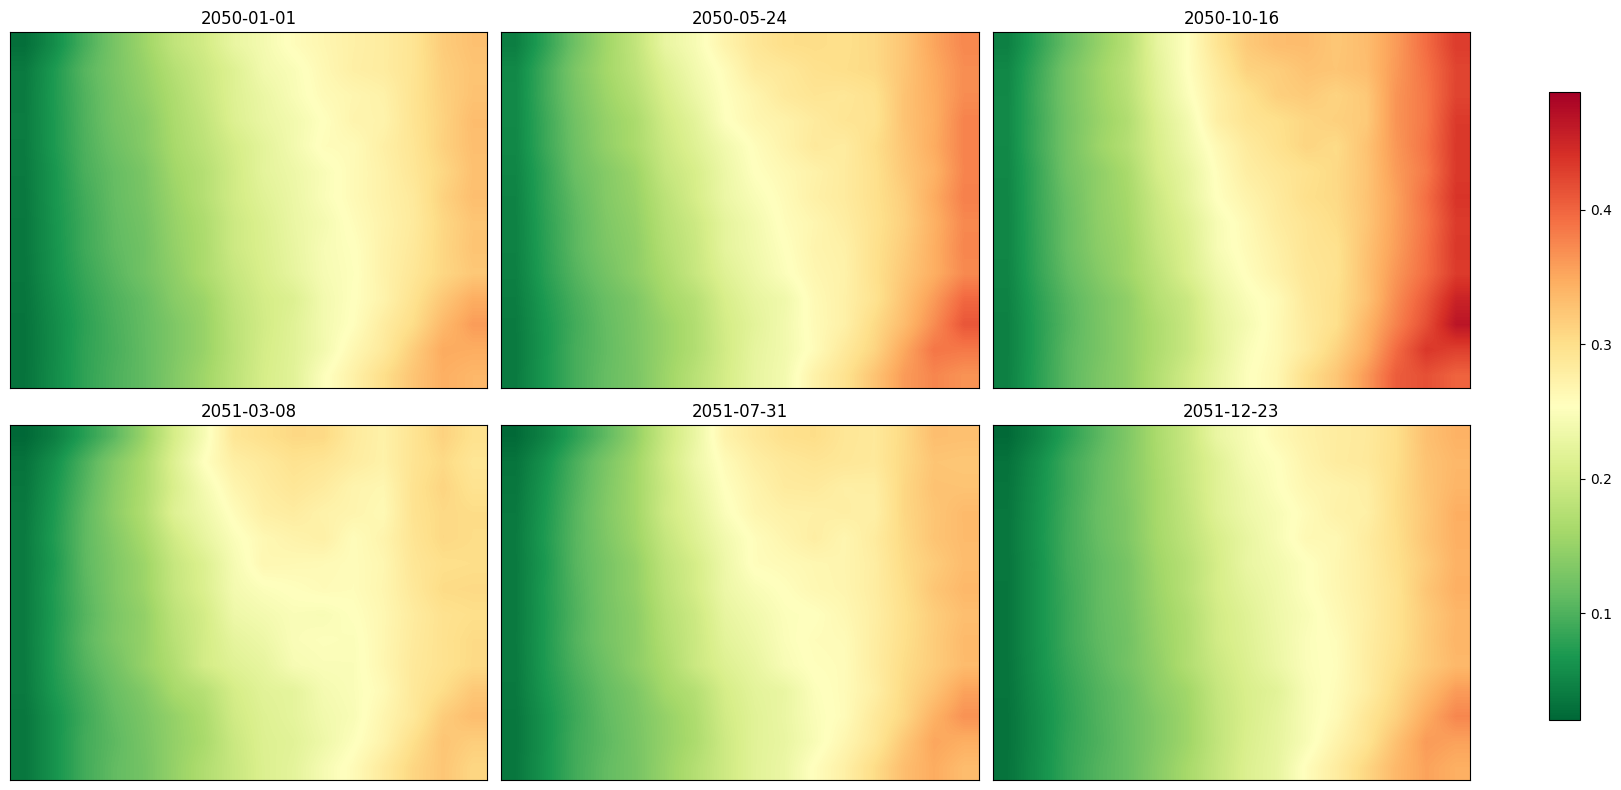

In [ ]:
# Surface evolution snapshots
def plot_evolution(df, n_snapshots=6, save=False):
    idxs = np.linspace(0, len(df)-1, n_snapshots, dtype=int)
    vmin = df[feature_cols].values.min()
    vmax = df[feature_cols].values.max()
    n_cols = 3
    n_rows = int(np.ceil(n_snapshots / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()
    for ax, i in zip(axes, idxs):
        surface = surface_for_date(df, i, unique_tenors, unique_maturities, tm_map)
        im = ax.imshow(surface, cmap='RdYlGn_r', aspect='auto', interpolation='bilinear', vmin=vmin, vmax=vmax)
        ax.set_title(df['Date'].iloc[i].date())
        ax.set_xticks([]); ax.set_yticks([])
    for ax in axes[len(idxs):]:
        ax.axis('off')
    fig.tight_layout()
    fig.colorbar(im, ax=axes, fraction=0.02)
    if save:
        path = os.path.join(PLOTS_DIR, 'evolution_snapshots.png')
        fig.savefig(path, dpi=200)
        print(f"Saved {path}")
    return fig

plot_evolution(df, n_snapshots=6, save=True)
plt.show()

### Evolution GIF

In [ ]:
def reshape_to_surface(df, date_idx, unique_tenors, unique_maturities, tenor_maturity_map):
    """
    Reshape flat data into 2D surface for a specific date.

    Returns:
        surface: 2D numpy array (tenor x maturity)
        date: The date for this surface
    """
    date = df['Date'].iloc[date_idx]
    row_data = df.iloc[date_idx]

    # Initialize surface
    surface = np.full((len(unique_tenors), len(unique_maturities)), np.nan)

    # Fill surface
    for col, (tenor, maturity) in tenor_maturity_map.items():
        tenor_idx = unique_tenors.index(tenor)
        maturity_idx = unique_maturities.index(maturity)
        surface[tenor_idx, maturity_idx] = row_data[col]

    return surface, date

def create_evolution_gif(df, unique_tenors, unique_maturities,
                        tenor_maturity_map, save_path='swaption_evolution.gif',
                        fps=5, max_frames=50):
    """
    Create an animated GIF showing surface evolution.

    Args:
        fps: Frames per second
        max_frames: Maximum number of frames (to avoid huge files)
    """
    try:
        from PIL import Image
        import io
    except ImportError:
        print("⚠ PIL/Pillow not installed. Skipping GIF creation.")
        print("  Install with: pip install Pillow")
        return None

    print(f"Creating evolution GIF with {min(len(df), max_frames)} frames...")

    # Select frames
    if len(df) > max_frames:
        frame_indices = np.linspace(0, len(df)-1, max_frames, dtype=int)
    else:
        frame_indices = range(len(df))

    # Global min/max for consistent colors
    vmin = df[[col for col in df.columns if col != 'Date']].min().min()
    vmax = df[[col for col in df.columns if col != 'Date']].max().max()

    frames = []

    for frame_num, idx in enumerate(frame_indices):
        if frame_num % 10 == 0:
            print(f"  Frame {frame_num+1}/{len(frame_indices)}...")

        # Create frame
        fig, ax = plt.subplots(figsize=(12, 8))

        surface, date = reshape_to_surface(df, idx, unique_tenors,
                                          unique_maturities, tenor_maturity_map)

        im = ax.imshow(surface, cmap='RdYlGn_r', aspect='auto',
                      interpolation='bilinear', vmin=vmin, vmax=vmax)

        # Format labels (simplified for animation)
        maturity_labels = [f'{int(m)}Y' if m >= 1 else f'{int(m*12)}M'
                          for m in unique_maturities[::2]]
        tenor_labels = [f'{int(t)}Y' for t in unique_tenors[::2]]

        ax.set_xticks(range(0, len(unique_maturities), 2))
        ax.set_yticks(range(0, len(unique_tenors), 2))
        ax.set_xticklabels(maturity_labels, rotation=45, ha='right')
        ax.set_yticklabels(tenor_labels)

        ax.set_xlabel('Maturity', fontsize=12, fontweight='bold')
        ax.set_ylabel('Tenor', fontsize=12, fontweight='bold')
        ax.set_title(f'Swaption Prices Surface\n{date.strftime("%Y-%m-%d")}',
                    fontsize=14, fontweight='bold')

        plt.colorbar(im, ax=ax, label='Swaption prices')
        plt.tight_layout()

        # Save frame to buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100)
        buf.seek(0)
        frames.append(Image.open(buf))
        plt.close(fig)

    # Save as GIF
    frames[0].save(save_path, save_all=True, append_images=frames[1:],
                   duration=int(1000/fps), loop=0, optimize=False)

    print(f"✓ Created GIF: {save_path}")
    return save_path



In [ ]:
gif_output_path = os.path.join(PLOTS_DIR, 'swaption_surface_evolution.gif')
created_gif_path = create_evolution_gif(df, unique_tenors, unique_maturities, tm_map, save_path=gif_output_path)

from IPython.display import Image
display(Image(filename=created_gif_path))

Output hidden; open in https://colab.research.google.com to view.